In [1]:
# Import necessary libraries
import os
import warnings
import requests
import librosa
import numpy as np
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column
from bokeh.models import Span, LinearColorMapper, ColorBar, FixedTicker

# Initialize Bokeh for notebook output
output_notebook()




In [2]:
# Define utility functions with docstrings
def download_audio(audio_url: str, local_path: str):
    """
    Download audio file from a URL to a local path.

    Parameters:
    - audio_url: URL of the audio file to download.
    - local_path: Local path to save the downloaded audio file.
    """
    if not os.path.exists(local_path):
        print(f"Downloading audio from {audio_url}...")
        response = requests.get(audio_url)
        response.raise_for_status()  # Raise an error for bad status
        with open(local_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded audio to {local_path}.")
    else:
        print(f"Audio file {local_path} already exists. Skipping download.")

def extract_features(y_segment: np.ndarray, sr: int, hop_length: int):
    """
    Extract various audio features from a segment.

    Parameters:
    - y_segment: Audio time series.
    - sr: Sampling rate.
    - hop_length: Hop length for feature calculation.

    Returns:
    - features: Dictionary containing extracted features.
    """
    features = {}
    features['amplitude_envelope'] = librosa.onset.onset_strength(y=y_segment, sr=sr, hop_length=hop_length)
    S = librosa.feature.melspectrogram(y=y_segment, sr=sr, hop_length=hop_length)
    features['melspectrogram'] = S
    features['spectral_flux'] = np.diff(S, axis=1)
    features['zero_crossing_rate'] = librosa.feature.zero_crossing_rate(y_segment, hop_length=hop_length)[0]
    features['spectral_centroid'] = librosa.feature.spectral_centroid(y=y_segment, sr=sr, hop_length=hop_length)[0]
    return features

def create_time_axis(num_frames: int, sr: int, hop_length: int, start_time: float):
    """
    Create a time axis for plotting.

    Parameters:
    - num_frames: Number of frames.
    - sr: Sampling rate.
    - hop_length: Hop length.
    - start_time: Start time in seconds.

    Returns:
    - Time axis array.
    """
    return librosa.frames_to_time(np.arange(num_frames), sr=sr, hop_length=hop_length) + start_time

def plot_stft_spectrogram(y_segment: np.ndarray, sr: int, n_fft: int, hop_length_stft: int, y_min: int, y_max: int, start_time: float, title: str, width=400, height=300, interp_factor=0.5):
    """
    Create a Bokeh figure for the STFT spectrogram.

    Parameters:
    - y_segment: Audio segment.
    - sr: Sampling rate.
    - n_fft: FFT window size.
    - hop_length_stft: Hop length for STFT.
    - y_min: Minimum frequency to display.
    - y_max: Maximum frequency to display.
    - start_time: Start time of the segment.
    - title: Plot title.
    - width: Plot width.
    - height: Plot height.
    - interp_factor: Interpolation factor between linear and log frequencies.

    Returns:
    - Bokeh figure.
    """
    stft = librosa.stft(y=y_segment, n_fft=n_fft, hop_length=hop_length_stft)
    stft_db_full = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    freqs_full = np.linspace(0, sr / 2, num=stft_db_full.shape[0])
    freq_indices = np.where((freqs_full >= y_min) & (freqs_full <= y_max))[0]

    stft_db = stft_db_full[freq_indices, :]
    freqs = freqs_full[freq_indices]

    # Interpolation between linear and log frequencies
    linear_freqs = np.linspace(y_min, y_max, num=len(freq_indices))
    log_freqs = np.logspace(np.log10(max(y_min, 1)), np.log10(y_max), num=len(freq_indices))
    interp_freqs = (1 - interp_factor) * linear_freqs + interp_factor * log_freqs

    num_ticks = min(10, len(interp_freqs))
    tick_indices = np.linspace(0, len(interp_freqs) - 1, num=num_ticks).astype(int)
    tick_locations = interp_freqs[tick_indices]
    tick_labels = [f"{int(freq)} Hz" for freq in tick_locations]

    p = figure(title=title, x_axis_label='Time (s)', y_axis_label='Frequency (Hz)',
               width=width, height=height, y_range=(y_min, y_max))

    color_mapper = LinearColorMapper(palette="Viridis256", low=np.min(stft_db), high=np.max(stft_db))

    times_stft = librosa.frames_to_time(np.arange(stft_db.shape[1]), sr=sr, hop_length=hop_length_stft) + start_time

    p.image(image=[stft_db],
            x=times_stft[0],
            y=y_min,
            dw=times_stft[-1] - times_stft[0],
            dh=y_max - y_min,
            color_mapper=color_mapper)

    p.yaxis.ticker = FixedTicker(ticks=tick_locations.tolist())
    p.yaxis.major_label_overrides = {freq: label for freq, label in zip(tick_locations, tick_labels)}

    color_bar = ColorBar(
        color_mapper=color_mapper,
        label_standoff=12,
        location=(0, 0),
        title='dB'
    )
    p.add_layout(color_bar, 'right')

    return p

def add_custom_lines(plot, custom_intervals, duration):
    """
    Add custom interval lines to a plot.

    Parameters:
    - plot: Bokeh figure to add lines to.
    - custom_intervals: List of dictionaries defining intervals.
    - duration: Duration of the audio segment.
    """
    for interval_set in custom_intervals:
        start = interval_set['start_time']
        step = interval_set['interval']
        color = interval_set.get('color', 'red')
        custom_time = start
        while custom_time < duration:
            span = Span(location=custom_time, dimension='height', line_color=color,
                        line_dash='dotted', line_width=2)
            plot.add_layout(span)
            custom_time += step


In [3]:
# Set parameters for audio processing
audio_url = 'https://github.com/egorpol/beat_it/raw/refs/heads/main/examples/vision_spectral_mono.aif'
local_audio_path = 'vision_spectral_mono.aif'

# Download and load the audio file
download_audio(audio_url, local_audio_path)

# Load audio using librosa
y, sr = librosa.load(local_audio_path)
duration = len(y) / sr
print(f"The audio file is {duration:.2f} seconds long.")


Downloaded audio to vision_spectral_mono.aif.
The audio file is 73.33 seconds long.


In [4]:
# STFT parameters
interp_factor = 0         # 0 for linear frequency scale, 1 for logarithmic
window_size = 1024
overlap = 0.5
hop_length_stft = int(window_size * (1 - overlap))
n_fft = window_size
y_min = 0                 # Minimum frequency to display in Hz
y_max = 10000             # Maximum frequency to display in Hz

# Parameters for grouped analysis
initial_start_time = 0.103       # Starting time of the first interval in seconds
interval_duration = 0.4582       # Duration of each custom interval in seconds
intervals_per_group = 32         # Number of intervals per group
total_groups = 4                 # Number of groups to analyze

# Compute start_times and end_times for each group
start_times_grouped = []
end_times_grouped = []

for group in range(total_groups):
    start_time = initial_start_time + group * intervals_per_group * interval_duration
    end_time = start_time + intervals_per_group * interval_duration
    # Ensure end_time does not exceed audio duration
    if end_time > duration:
        end_time = duration
    start_times_grouped.append(start_time)
    end_times_grouped.append(end_time)

print("Grouped Segments (Start - End in seconds):")
for idx, (s, e) in enumerate(zip(start_times_grouped, end_times_grouped), 1):
    print(f"Group {idx}: {s:.3f} - {e:.3f} s")


Grouped Segments (Start - End in seconds):
Group 1: 0.103 - 14.765 s
Group 2: 14.765 - 29.428 s
Group 3: 29.428 - 44.090 s
Group 4: 44.090 - 58.753 s


In [5]:
# Define custom interval lines (e.g., beat intervals)
custom_intervals = [
    {'start_time': 0.103, 'interval': 0.4582, 'color': 'orange'},
    # Add more custom intervals here if needed
]


In [6]:
# Process each grouped segment and plot the STFT spectrogram
group_layouts = []  # List to hold layouts for each group

for idx, (start_time, end_time) in enumerate(zip(start_times_grouped, end_times_grouped), 1):
    print(f"\nProcessing Group {idx}: {start_time:.3f} - {end_time:.3f} seconds")

    # Extract the audio segment for the current group
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    y_segment = y[start_sample:end_sample]

    # Plot STFT spectrogram
    p_stft = plot_stft_spectrogram(
        y_segment, sr, n_fft, hop_length_stft, y_min, y_max,
        start_time, f"STFT Spectrogram (Group {idx})", width=1200, height=600, interp_factor=interp_factor
    )

    # Add custom interval lines to the plot
    add_custom_lines(p_stft, custom_intervals, end_time)

    # Add the plot to the list of group layouts
    group_layouts.append(p_stft)

# Arrange all group layouts vertically and display
final_layout = column(*group_layouts, sizing_mode='stretch_both')
show(final_layout)


Output hidden; open in https://colab.research.google.com to view.

In [7]:
import numpy as np
from scipy.spatial.distance import cosine

# List to store flattened STFT spectrograms for each group
stft_vectors = []

for idx, (start_time, end_time) in enumerate(zip(start_times_grouped, end_times_grouped), 1):
    # Extract the audio segment
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    y_segment = y[start_sample:end_sample]

    # Compute STFT
    stft = librosa.stft(y=y_segment, n_fft=n_fft, hop_length=hop_length_stft)
    stft_magnitude = np.abs(stft)

    # Flatten the magnitude spectrogram
    stft_vector = stft_magnitude.flatten()

    # Normalize the vector
    stft_vector /= np.linalg.norm(stft_vector)

    stft_vectors.append(stft_vector)

# Initialize similarity matrix
num_groups = len(stft_vectors)
similarity_matrix = np.zeros((num_groups, num_groups))

# Compute pairwise cosine similarity
for i in range(num_groups):
    for j in range(num_groups):
        similarity = 1 - cosine(stft_vectors[i], stft_vectors[j])
        similarity_matrix[i, j] = similarity

# Display the similarity matrix
print("Pairwise Cosine Similarities between Groups:")
print(similarity_matrix)


Pairwise Cosine Similarities between Groups:
[[1.         0.95164469 0.94994353 0.94551739]
 [0.95164469 1.         0.95586015 0.95153916]
 [0.94994353 0.95586015 1.         0.95594179]
 [0.94551739 0.95153916 0.95594179 1.        ]]


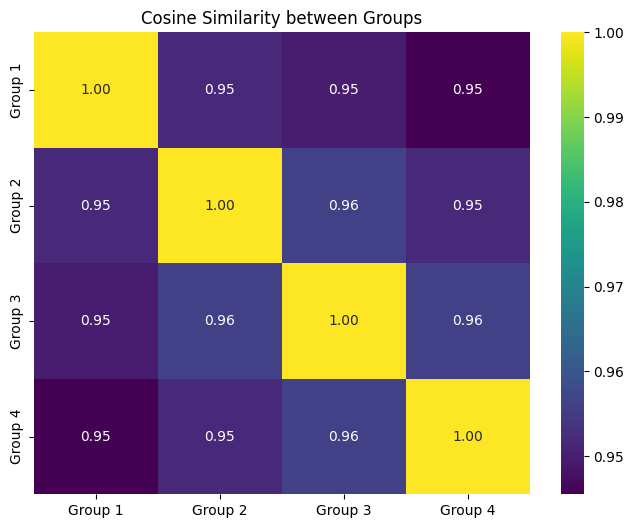

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap
group_labels = [f'Group {i+1}' for i in range(num_groups)]
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap='viridis',
            xticklabels=group_labels, yticklabels=group_labels)
plt.title('Cosine Similarity between Groups')
plt.show()
